# Predicting sport specific performance from field testing in synchronized swimming
Romain Martinez ([GitHub](https://github.com/romainmartinez))

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

In [2]:
import altair as alt

In [3]:
NORMALIZE = 'weight'

## Get the data

In [4]:
DATA_PATH = Path("./data/zTable.xlsx")
df = pd.read_excel(DATA_PATH)

df.head()

,Name,Height,Weight,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,...,FLEX/D,EB max force,EB mean force,EB sd force,EB max height,EB min height,EB mean height,EB sd height,EB max-min height,BB
0,'aissatou_sougou',1.69,48.52,287.05,285.00,206.85,179.90,92.85,94.95,52.3,...,146.00,8.33,6.770000,0.439447,8.5,7.5,8.083333,0.376386,1.0,9.5
1,'anais_charland',1.63,62.13,292.75,302.75,239.85,207.85,109.25,103.25,98.4,...,123.35,9.43,7.762753,0.584721,7.5,7.0,7.083333,0.204124,0.5,8.5
2,'anne sophie_moreau',1.71,54.90,252.40,258.55,233.45,233.65,69.30,68.80,120.0,...,204.80,8.76,6.725683,0.767079,8.0,7.5,7.833333,0.258199,0.5,8.5
3,'audrey_lamothe',1.50,43.44,213.45,227.40,174.00,132.10,54.20,56.40,39.9,...,112.25,9.86,7.315823,0.815853,8.0,7.0,7.416667,0.376386,1.0,8.5
4,'billie_francis',1.78,62.04,281.75,296.20,258.65,227.25,97.25,99.05,77.2,...,152.85,10.77,8.995158,0.570680,7.5,7.0,7.333333,0.258199,0.5,9.0


### Drop (very) low forces

In [5]:
threshold = 4  # kg
to_drop = (df.filter(like="/") < threshold).any(axis=1)
print(f"remove {to_drop.sum()} rows that are < to {threshold} kg")

df = df.loc[~to_drop, :]

remove 1 rows that are < to 4 kg


In [6]:
# variables
variables = [
    "ADD/G",
    "ADD/D",
    "ABD/G",
    "ABD/D",
    "ER/G",
    "ER/D",
    "IR/G",
    "IR/D",
    "EXT/G",
    "EXT/D",
    "FLEX/G",
    "FLEX/D",
]
X = df[variables] / 9.81
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,29.260958,29.051988,21.085627,18.338430,9.464832,9.678899,5.331295,5.295617,16.987768,20.050968,18.654434,14.882773
1,29.841998,30.861366,24.449541,21.187564,11.136595,10.524975,10.030581,8.567788,31.396534,26.243629,15.963303,12.573904
2,25.728848,26.355759,23.797146,23.817533,7.064220,7.013252,12.232416,12.212029,14.383282,11.539246,20.341488,20.876656
4,28.720693,30.193680,26.365953,23.165138,9.913354,10.096840,7.869521,6.365953,21.116208,17.018349,16.156983,15.581040
5,32.951070,NaN,33.741081,36.472987,9.449541,9.903160,14.923547,14.500510,23.470948,14.556575,20.489297,20.530071


In [7]:
targets = ["BB", "EB mean height", "EB mean force"]
y = df[targets].rename(
    columns={"BB": "BB-H", "EB mean height": "EB-H", "EB mean force": "EB-F"}
)
y.head()

,BB-H,EB-H,EB-F
0,9.5,8.083333,6.770000
1,8.5,7.083333,7.762753
2,8.5,7.833333,6.725683
4,9.0,7.333333,8.995158
5,9.0,7.916667,8.098323


## Normalize data
We should normalize the field tests (`X`) by anthropometric measurements.

In [8]:
if NORMALIZE == "weight":
    normalizer = df["Weight"]
elif NORMALIZE == "IMC":
    normalizer = df["Weight"] / df["Height"] ** 2
elif NORMALIZE == "weight-height":
    normalizer = df["Weight"] * df["Height"]
else:
    normalizer = 1
    print("data not normalized")
X = X.divide(normalizer, axis=0)

## NaN remover

In [9]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
#     X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]
    X.iloc[i[0], i[1]] = X.iloc[i[0], replacer]

participant no.: 4
	test: ADD/D
		"nan" replace by "0.5440163502788746"
participant no.: 40
	test: IR/G
		"nan" replace by "0.20208970438328236"
participant no.: 89
	test: IR/G
		"nan" replace by "0.21868999359931726"


## Data description

### Variables $X$
Hip strength tests (field testing):
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test

### Targets $y$

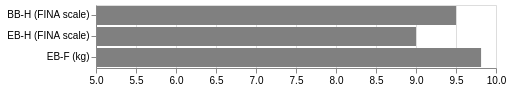

In [10]:
test_cols_renamed = {
    "BB-H": "BB-H (FINA scale)",
    "EB-H": "EB-H (FINA scale)",
    "EB-F": "EB-F (kg)",
}

test_cols_order = ["BB-H (FINA scale)", "EB-H (FINA scale)", "EB-F (kg)"]

(
    alt.Chart(y.rename(columns=test_cols_renamed).melt())
    .mark_bar(color="grey")
    .encode(
        alt.X(
            "value",
            title="",
            scale=alt.Scale(zero=False),
            axis=alt.Axis(labelFlush=False),
        ),
        alt.Y("variable", title=None, scale=alt.Scale(domain=test_cols_order)),
    )
)

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [11]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance

In [12]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [13]:
X_augmented = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_augmented[name[:-2]] = f_score(a, b)
        X_augmented[f'imb. {name[:-2]}'] = imbalance(a, b)

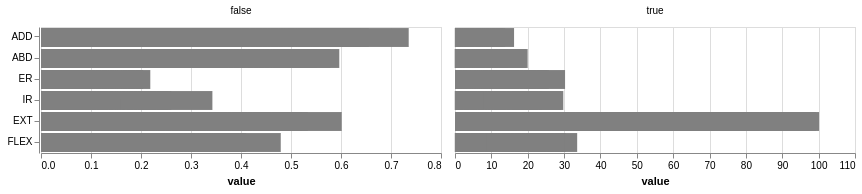

In [14]:
test_cols = ["ADD", "ABD", "ER", "IR", "EXT", "FLEX"]

alt.Chart().mark_bar(color="grey").encode(
    alt.X("value"), alt.Y("variable", title=None, scale=alt.Scale(domain=test_cols))
).facet(
    data=X_augmented.melt().assign(
        imb=lambda x: x["variable"].str[:3] == "imb",
        variable=lambda x: x["variable"].str.replace("imb. ", ""),
    ),
    column=alt.Column("imb", title=None),
).resolve_scale(
    x="independent"
)

### Anthropometry

In [15]:
X_augmented['Height'] = df['Height']
X_augmented['Mass'] = df['Weight']

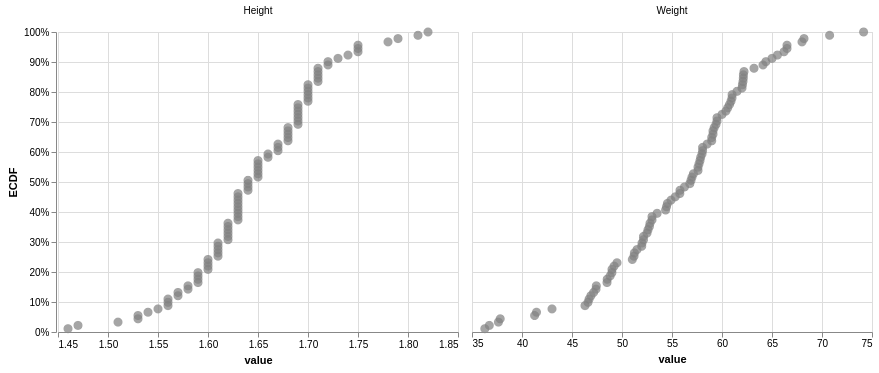

In [16]:
alt.Chart().mark_circle(color="grey", size=80).encode(
    alt.X("value", scale=alt.Scale(zero=False)),
    alt.Y("ECDF", axis=alt.Axis(format="%")),
).facet(
    data=df[["Height", "Weight"]]
    .melt()
    .assign(
        ECDF=lambda d: d.groupby("variable").transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    ),
    column=alt.Column("variable", title=None),
).resolve_scale(
    x="independent"
)

## Fitting an ensemble model

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y, test_size=0.2, random_state=RANDOM_SEED
)

### Helper functions

In [18]:
from sklearn.metrics import mean_squared_error


def mape(y_test, y_pred):
    return (np.abs((y_test - y_pred) / y_test)) * 100


def mae(y_test, y_pred):
    return np.abs(y_test - y_pred)


def evaluate(y_test, y_pred):
    d = {"mae": mae(y_test, y_pred), "mape": mape(y_test, y_pred)}
    print(
        f"""
    \tmae = {d['mae'].mean():.3f} ({d['mae'].std():.3f})
    \tmape = {d['mape'].mean():.3f}% ({d['mape'].std():.3f})
    """
    )
    return d

In [19]:
# from skopt import BayesSearchCV, dump, load


# class BayesSearch:
#     def __init__(self, model, search_spaces, n_iter, export_path):
#         self.export_path = export_path
#         self.bayes_cv_tuner = BayesSearchCV(
#             model,
#             search_spaces,
#             cv=5,
#             n_jobs=-1,
#             n_iter=n_iter,
#             verbose=0,
#             refit=True,
#             random_state=RANDOM_SEED,
#         )

#     def fit(self, X, y):
#         self.bayes_cv_tuner.fit(X, y, callback=self.print_status)
#         self.export_results()

#     def export_results(self):
#         pd.DataFrame(self.bayes_cv_tuner.cv_results_).to_csv(
#             f"{self.export_path}_cv_results.csv"
#         )
#         pd.Series(self.bayes_cv_tuner.best_params_).to_json(
#             f"{self.export_path}_best_params.json"
#         )
#         dump(self.bayes_cv_tuner, f"{self.export_path}_bayes_search.pkl")

#     def print_status(self, optim_results):
#         print(
#             f"""
# Model #{len(opt.bayes_cv_tuner.cv_results_['params'])}
# Best: {self.bayes_cv_tuner.best_score_}
# Best params: {self.bayes_cv_tuner.best_params_}
#         """
#         )

### Fit model

In [20]:
from xgboost import XGBRegressor

OPT = False
ITERATIONS = 100

params = {"n_jobs": 1, "silent": 1, "tree_method": "approx"}

if OPT:
    for itarget in y.columns:
        OPT_EXPORT = f"opt/{itarget}"

        search_spaces = {
            "learning_rate": (0.01, 1.0, "log-uniform"),
            "min_child_weight": (0, 10),
            "max_depth": (0, 50),
            "max_delta_step": (0, 20),
            "subsample": (0.01, 1.0, "uniform"),
            "colsample_bytree": (0.01, 1.0, "uniform"),
            "colsample_bylevel": (0.01, 1.0, "un|iform"),
            "reg_lambda": (1e-9, 1000, "log-uniform"),
            "reg_alpha": (1e-9, 1.0, "log-uniform"),
            "gamma": (1e-9, 0.5, "log-uniform"),
            "min_child_weight": (0, 5),
            "n_estimators": (50, 100),
            "scale_pos_weight": (1e-6, 500, "log-uniform"),
        }

        opt = BayesSearch(
            model=XGBRegressor(**params),
            search_spaces=search_spaces,
            n_iter=ITERATIONS,
            export_path=OPT_EXPORT,
        )
        opt.fit(X_train, y_train[itarget])

In [21]:
USE_OPT = False

boosted = {}
evaluation = {}


for itarget, itarget_name in enumerate(y_train.columns):
    print(f"\t{itarget}. {itarget_name}\n")

    opt_params = (
        load(f"opt/{itarget_name}_bayes_search.pkl").best_params_ if USE_OPT else {}
    )

    boosted[itarget_name] = XGBRegressor(
        **{**params, **opt_params}, random_state=RANDOM_SEED
    )
    boosted[itarget_name].fit(
        X_train,
        y_train[itarget_name],
        eval_set=[(X_train, y_train[itarget_name]), (X_test, y_test[itarget_name])],
        early_stopping_rounds=50,
        eval_metric="rmse",
        verbose=50,
    )

    evaluation[itarget_name] = evaluate(
        y_test[itarget_name], boosted[itarget_name].predict(X_test)
    )
    evaluation[itarget_name]["test"] = [
        itarget_name for i in range(len(evaluation[itarget_name]["mae"]))
    ]

    print(f'{"-" * 30}\n')
evaluation = pd.concat([pd.DataFrame(evaluation[itest]) for itest in evaluation.keys()])

	0. BB-H

[0]	validation_0-rmse:7.41718	validation_1-rmse:7.59897
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.179712	validation_1-rmse:0.575967
[99]	validation_0-rmse:0.056988	validation_1-rmse:0.566627

    	mae = 0.431 (0.376)
    	mape = 4.816% (4.160)
    
------------------------------

	1. EB-H

[0]	validation_0-rmse:6.36404	validation_1-rmse:6.39404
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.219782	validation_1-rmse:0.447556
[99]	validation_0-rmse:0.07483	validation_1-rmse:0.444485

    	mae = 0.373 (0.235)
    	mape = 4.906% (2.976)
    
------------------------------

	2. EB-F

[0]	validation_0-rmse:6.13639	validation_1-rmse:5.9381
Multiple eval metrics have been passed: 'validation_1-rmse' will be us

/home/romain/miniconda3/envs/synchro/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/romain/miniconda3/envs/synchro/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


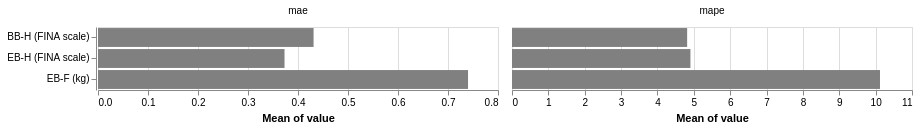

In [22]:
alt.Chart().mark_bar(color="grey").encode(
    alt.X("mean(value)"),
    alt.Y("test", title=None, scale=alt.Scale(domain=test_cols_order)),
).facet(
    data=evaluation.replace(test_cols_renamed).melt(id_vars="test"),
    column=alt.Column("variable", title=None),
).resolve_scale(
    x="independent"
)

In [23]:
ecdf = (
    evaluation.replace(test_cols_renamed)
    .melt(id_vars="test")
    .assign(
        ECDF=lambda d: d.groupby(["test", "variable"]).transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
)
ecdf.head()

,test,variable,value,ECDF
0,BB-H (FINA scale),mae,1.169546,1.000000
1,BB-H (FINA scale),mae,0.183525,0.315789
2,BB-H (FINA scale),mae,0.083184,0.157895
3,BB-H (FINA scale),mae,0.940316,0.842105
4,BB-H (FINA scale),mae,0.269014,0.526316


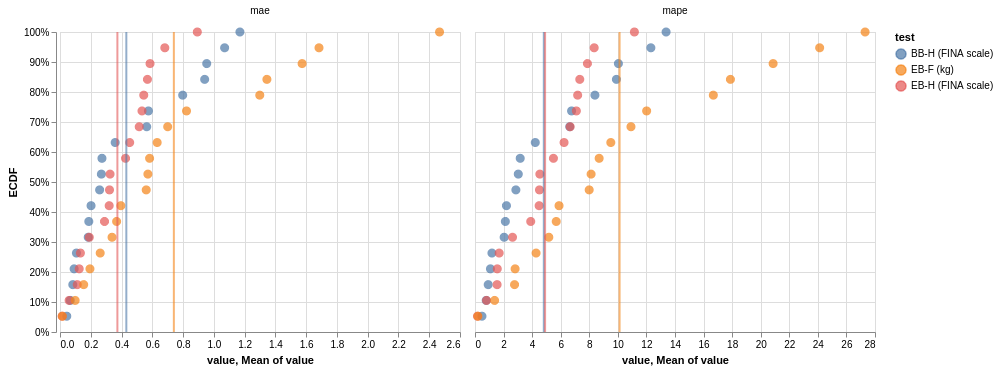

In [24]:
point = (
    alt.Chart()
    .mark_circle(size=80)
    .encode(
        alt.X("value"),
        alt.Y("ECDF", axis=alt.Axis(format="%")),
        alt.Color("test", sort=test_cols_order),
    )
)

rule = (
    alt.Chart()
    .mark_rule(size=2, opacity=0.6)
    .encode(alt.X("mean(value)"), alt.Color("test", sort=test_cols_order))
)

(point + rule).facet(
    data=ecdf, column=alt.Column("variable", title=None)
).resolve_scale(x="independent")

### Bayesian Estimation Supersedes the T-Test

This model replicates the example used in: Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.

In [25]:
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
import pymc3 as pm


def best(data, value, group):
    """
    This model replicates the example used in:
    Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.
    The original model is extended to handle multiple groups.

    Parameters
    ----------
    data: pandas.DataFrame
        Tidy pandas dataframe
    value: str
        Name of the column holding the values
    group: str
        Name of the column holding the groups
    Returns
    -------
    pymc3.Model
    """
    groups = data[group].unique()

    # pooled empirical mean of the data and twice the pooled empirical standard deviation
    mu = data[value].mean()
    sd = data[value].std() * 2

    # group standard deviations priors
    σ = [0.5, 3]

    with pm.Model() as model:
        groups_means = {
            igroup: pm.Normal(f"{igroup}_mean", mu=mu, sd=sd) for igroup in groups
        }
        groups_std = {
            igroup: pm.Uniform(f"{igroup}_std", lower=σ[0], upper=σ[-1])
            for igroup in groups
        }

        # prior for ν exponentially distributed with a mean of 30
        ν = pm.Exponential("ν_minus_one", lam=1 / 29.0) + 1

        # precision (transformed from standard deviations)
        λ = {igroup: groups_std[igroup] ** -2 for igroup in groups}

        likelihoods = {
            igroup: pm.StudentT(
                igroup,
                nu=ν,
                mu=groups_means[igroup],
                lam=λ[igroup],
                observed=data.query(f'{group} == "{igroup}"')[value].dropna(),
            )
            for igroup in groups
        }

        delta_means, delta_std, effect_size = {}, {}, {}
        for a, b in combinations(groups, 2):
            a_minus_b = f"{a} - {b}"
            delta_means[a_minus_b] = pm.Deterministic(
                f"Δμ ({a_minus_b})", groups_means[a] - groups_means[b]
            )
            delta_std[a_minus_b] = pm.Deterministic(
                f"Δσ ({a_minus_b})", groups_std[a] - groups_std[b]
            )
            effect_size[a_minus_b] = pm.Deterministic(
                f"effect size ({a_minus_b})",
                delta_means[a_minus_b]
                / np.sqrt((groups_std[a] ** 2 + groups_std[b] ** 2) / 2),
            )
    return model

In [26]:
SAMPLE = True
MODEL_PATH = Path("./models/stats")

trace = {}
for itarget, itarget_name in enumerate(y_train.columns):
    print(f"\t{itarget}. {itarget_name}\n")

    d = pd.DataFrame(
        {"test": y_test[itarget_name], "pred": boosted[itarget_name].predict(X_test)}
    ).melt(var_name="group", value_name="mva")

    m = best(data=d, value="mva", group="group")
    with m:
        if SAMPLE:
            trace[itarget_name] = pm.sample(10_000, tune=10_000, random_seed=RANDOM_SEED)
            pm.save_trace(
                trace[itarget_name], directory=MODEL_PATH / itarget_name, overwrite=True
            )
        else:
            trace[itarget_name] = pm.load_trace(MODEL_PATH / itarget_name, model=m)

	0. BB-H



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, pred_std, test_std, pred_mean, test_mean]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:33<00:00, 2378.25draws/s]
The acceptance probability does not match the target. It is 0.8904693253245906, but should be close to 0.8. Try to increase the number of tuning steps.


	1. EB-H



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, pred_std, test_std, pred_mean, test_mean]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:34<00:00, 2337.89draws/s]


	2. EB-F



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, pred_std, test_std, pred_mean, test_mean]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:36<00:00, 2220.81draws/s]
The acceptance probability does not match the target. It is 0.895876241501174, but should be close to 0.8. Try to increase the number of tuning steps.


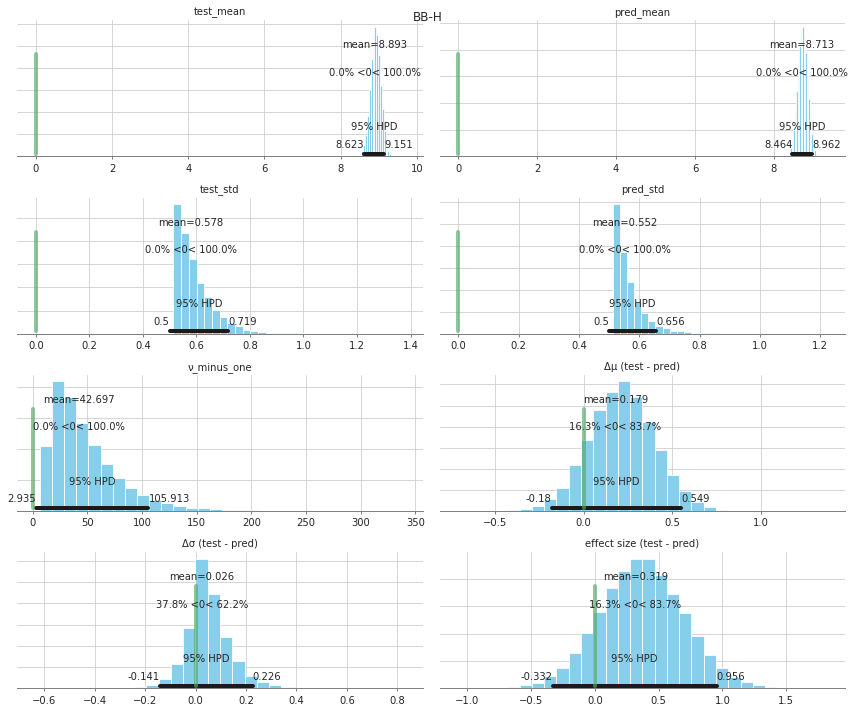

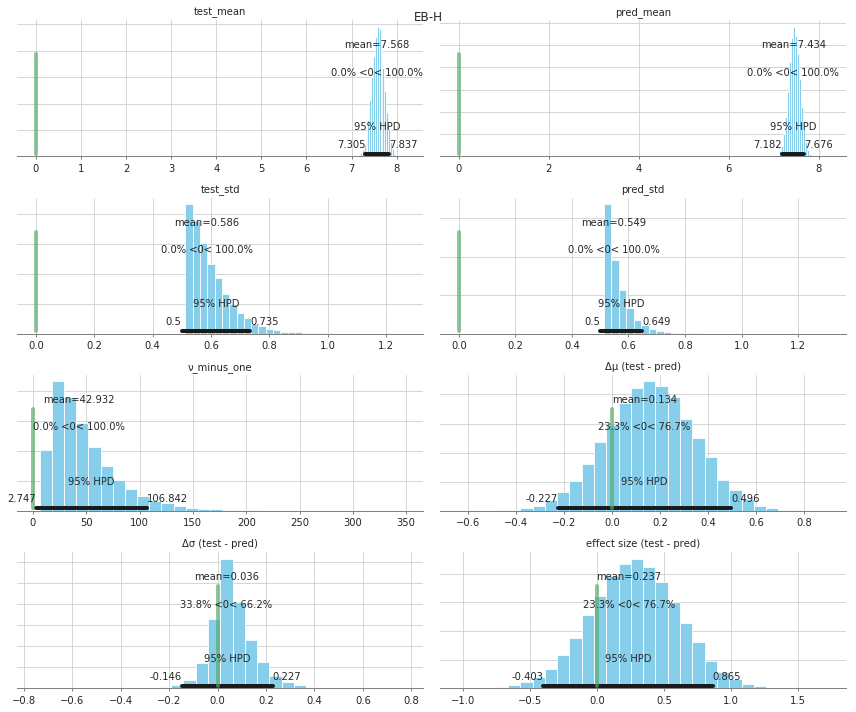

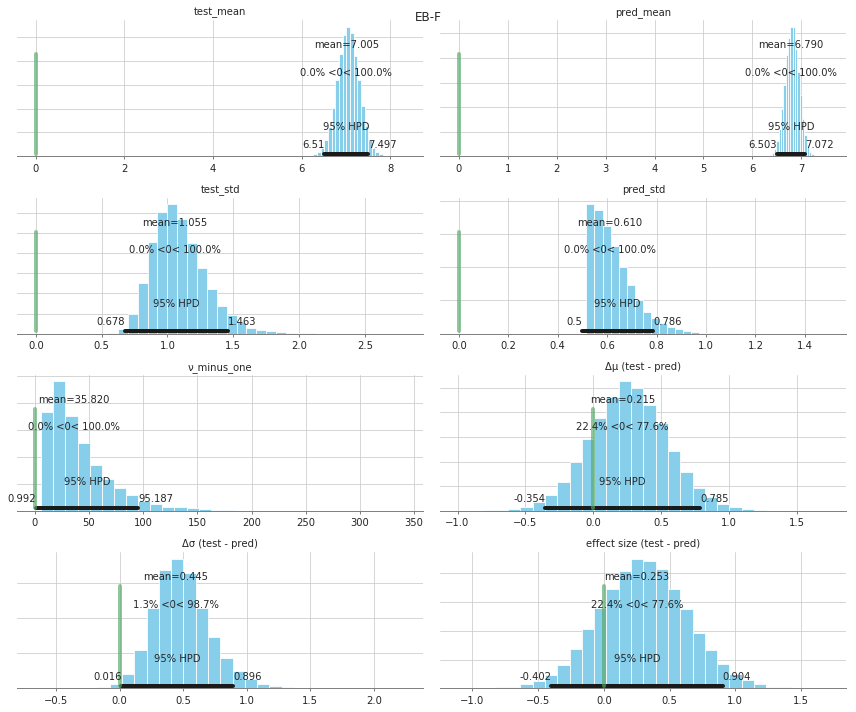

In [27]:
for itarget, itrace in trace.items():
    trace_vars = pm.trace_to_dataframe(itrace)
    pm.plot_posterior(itrace, ref_val=0)
    plt.suptitle(itarget)
    plt.tight_layout()

## Interpretation

In [28]:
X_augmented.iloc[[28]]

,ADD,imb. ADD,ABD,imb. ABD,ER,imb. ER,IR,imb. IR,EXT,imb. EXT,FLEX,imb. FLEX,Height,Mass
29,0.6395,9.541731,0.435201,12.380122,0.159422,15.57377,0.151253,0.357462,0.226554,17.94181,0.395795,15.254237,1.46,37.64


In [29]:
import shap

shap.initjs()

explainer = {itarget: shap.TreeExplainer(boosted[itarget]) for itarget in y.columns}
shap_values = {
    itarget: explainer[itarget].shap_values(X_augmented) for itarget in y.columns
}

### How important are our features?
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

In [30]:
shap_df = pd.concat(
    [
        pd.DataFrame(shap_values[i], columns=X_train.columns).assign(target=i)
        for i in y.columns
    ]
)

In [31]:
shap_df_abs = shap_df.copy()
shap_df_abs[X_train.columns] = shap_df_abs[X_train.columns].abs()

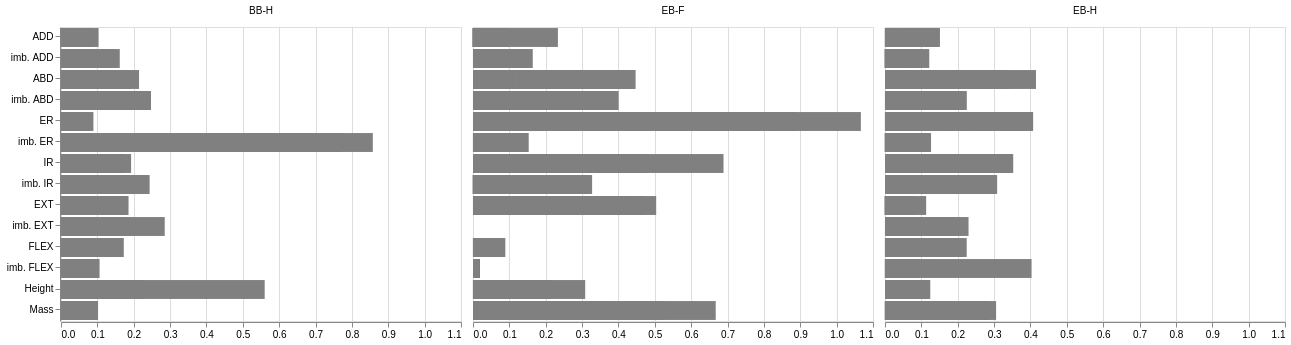

In [32]:
alt.Chart(shap_df_abs.melt(id_vars="target")).mark_bar(color="grey").encode(
    alt.X("value", title=None),
    alt.Y(
        "variable",
        title=None,
        scale=alt.Scale(domain=shap_df_abs.drop("target", axis=1).columns.tolist()),
    ),
    alt.Column("target", title=None),
)

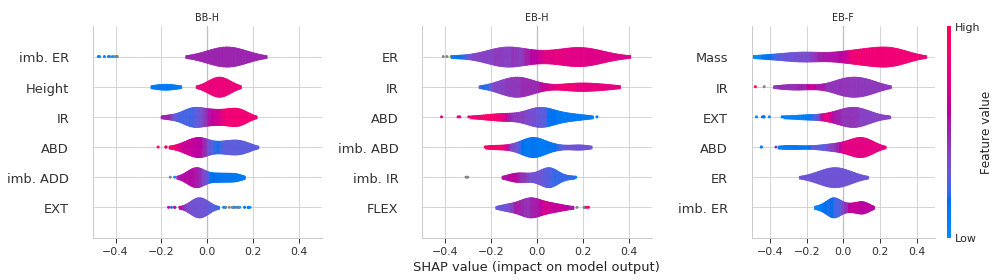

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
MAX_DISPLAY = 6

for i, itarget in enumerate(y.columns):
    color_bar = True if i == 2 else False

    plt.sca(ax[i])
    shap.summary_plot(
        shap_values[itarget],
        X_augmented,
        show=False,
        color_bar=color_bar,
        auto_size_plot=False,
        max_display=MAX_DISPLAY,
        plot_type="violin",
    )
    ax[i].set_title(itarget)
    ax[i].set_xlim(-0.5, 0.5)
    if i != 1:
        ax[i].set_xlabel("")
plt.tight_layout()
sns.despine()
plt.savefig("/home/romain/Downloads/shap.svg", dpi=300)


### What is the prediction path?
The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [34]:
random_observation = np.random.randint(0, X_augmented.shape[0])

itarget = y.columns[0]

shap.force_plot(
    explainer[itarget].expected_value,
    shap_values[itarget][random_observation, :],
    X_augmented.iloc[random_observation, :],
)

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset

In [35]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [36]:
shap.force_plot(
    explainer[itarget].expected_value,
    shap_values[itarget][random_observation, :],
    X_augmented.iloc[random_observation, :],
)

In [37]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [38]:
itarget = y.columns[2]

shap.force_plot(
    explainer[itarget].expected_value,
    shap_values[itarget][random_observation, :],
    X_augmented.iloc[random_observation, :],
)

In [39]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

### How is target variable related with important features?
The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all observations we can see how changes in the feature's value effect the model's output.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in fatigue as AveShEleMean changes.

Vertical dispersion at a single value of AveShEleMean represents interaction effects with other features.

To help reveal these interactions dependence_plot automatically selects another feature for coloring.

In this case coloring by ROMTrYMean highlights that AveShEleMean has less impact on fatigue when ROMTrXMean decreases and conversely.

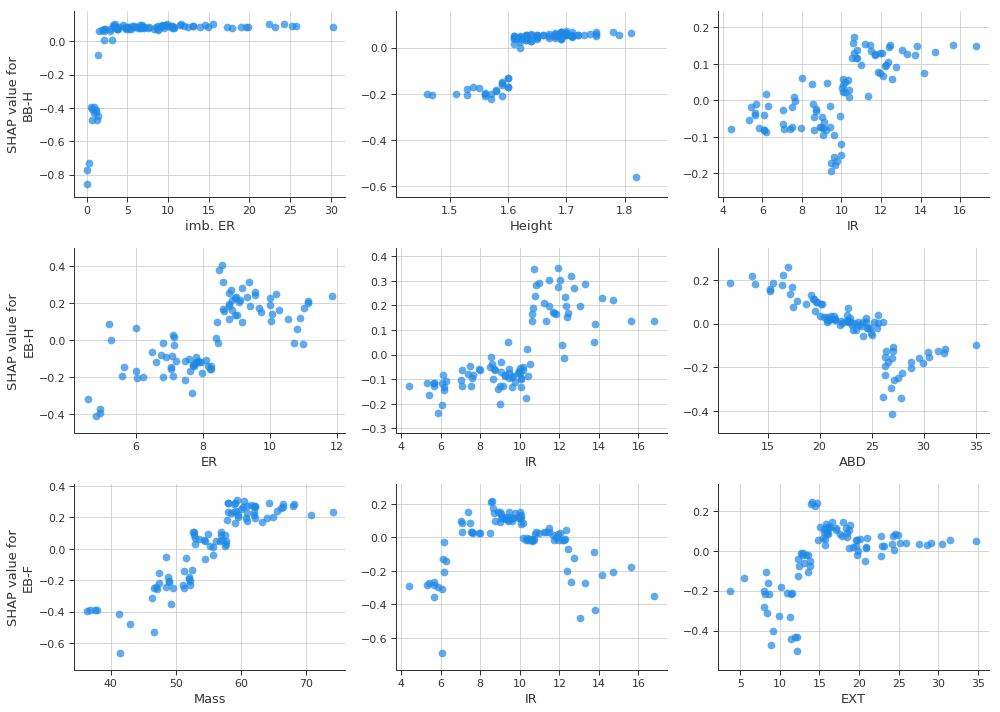

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))

for irow, itarget in enumerate(y.columns):
    # sort the features indexes by their importance in the model
    # (sum of SHAP value magnitudes over the validation dataset)
    top_inds = np.argsort(-np.sum(np.abs(shap_values[itarget]), axis=0))

    # make SHAP plots of the three most important features and their best interaction
    for icol, idx in enumerate(top_inds[:3]):
        plt.sca(ax[irow, icol])

        shap.dependence_plot(
            idx,
            shap_values[itarget],
            X_augmented,
            dot_size=60,
            interaction_index=None,
            alpha=0.7,
            show=False,
        )
        ax[irow, icol].set_ylabel("")
    ax[irow, 0].set_ylabel(f"SHAP value for\n{itarget}")

plt.gcf().set_size_inches(14, 10)
plt.tight_layout()
sns.despine()

### Supervised clustering
Clustering people by their shap values leads to groups relevent to the prediction task at hand.

In [40]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

itarget = y.columns[0]

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[itarget][:, :-1])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(
    shap_values[itarget][:, :-1]
)

In [41]:
def plot_clusters(x, y, c, label, a):
    a.scatter(x, y, c=c, linewidth=0, alpha=0.8, s=60)
    PCM = a.get_children()[0]
    cb = plt.colorbar(PCM, label=label, aspect=40, orientation="horizontal", ax=a)
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params("x", length=0)
    cb.ax.xaxis.set_label_position("top")
    a.axis("off")

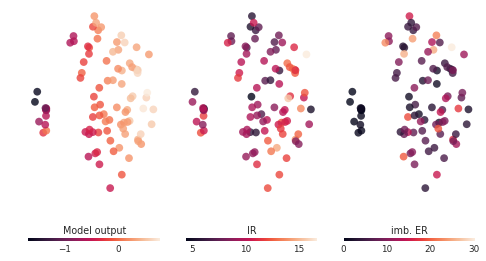

In [42]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=np.sum(shap_values[itarget], axis=1),
    a=ax[0],
    label="Model output",
)

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented["IR"],
    a=ax[1],
    label="IR",
)

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented["imb. ER"],
    a=ax[2],
    label="imb. ER",
)

plt.show()

## Sensitivity Analysis

### What is the impact of a 5% increase of each variable on the target variable?

### How to improve by 0.5 on the FINA scale with the minimum force increase?

In [43]:
imb_cols = X_augmented.filter(like="imb").columns.tolist()
anthropo_cols = ["Height", "Mass"]
force_cols = X_augmented.drop(imb_cols + anthropo_cols, axis=1).columns.tolist()

In [44]:
def solutions_to_df(algo):
    df_columns = force_cols + imb_cols + ["obj_principal", "obj_force", "obj_imb"]
    return (
        pd.concat(
            [
                pd.DataFrame(
                    [
                        isolution.variables
                        + [
                            isolution.objectives[0],
                            isolution.objectives[1],
                            isolution.objectives[2],
                        ]
                    ],
                    columns=df_columns,
                )
                for isolution in pp.unique(pp.nondominated(algo.result))
            ]
        )
        .eval("sum = obj_principal + obj_force + obj_imb")
        .sort_values("sum")
    )

In [250]:
X_augmented[force_cols].sum(axis=1).sort_values().index

Int64Index([28, 12, 49,  6, 86, 24, 13, 29, 58, 44, 84, 23, 75, 56, 71, 42, 15,
            79, 11, 89, 18, 22, 40, 10, 78, 37, 87, 46, 51, 20,  7, 27, 70, 80,
             8, 35, 57, 30, 17,  0, 25, 61, 63, 72, 26, 21, 69, 19, 73, 81, 65,
             2, 67, 64, 36, 85, 47, 88, 82,  4, 45, 14, 38, 74, 34, 68, 53, 32,
            39, 48, 76, 59, 16, 66,  1, 91, 43, 90, 83, 41, 55, 62, 60, 50, 54,
            77,  5, 52,  9, 31, 33],
           dtype='int64')

In [307]:
10-8.5

0.5

In [305]:
10.5-10

0.5

In [326]:
import platypus as pp
import random

random.seed(RANDOM_SEED)

n_var = len(imb_cols) + len(force_cols)
n_obj = 3
iterations = 10_000
MODEL_PATH = Path("./models/opt/")
n = range(5)
n = range(50, 20)
n = [
    28,
    12,
    49,
    6,
    86,
    24,
    13,
    29,
    58,
    44,
    84,
    23,
    75,
    56,
    71,
    42,
    15,
    79,
    11,
    89,
    18,
    22,
    40,
    10,
    78,
    37,
    87,
    46,
]

OPT = True

if OPT:
    for itarget in y.drop("EB-F", axis=1):
        print(itarget)

        shap_weight = (
            shap_df.query("target == @itarget")
            .drop(["target"] + anthropo_cols, axis=1)
            .abs()
            .mean()
        )
        shap_ponderation = 1 - shap_weight / shap_weight.sum()

        for iparticipant in n:
            print(f"\t{iparticipant}")
            irow = X_augmented.iloc[[iparticipant]].drop(anthropo_cols, axis=1)
            anthropo = X_augmented.iloc[[iparticipant]][anthropo_cols]
            initial_pred = boosted[itarget].predict(X_augmented.iloc[[iparticipant]])
            desired_pred = initial_pred + 0.5

            class Problem(pp.Problem):
                def __init__(self):
                    super(Problem, self).__init__(n_var, n_obj)
                    self.set_types()

                def set_types(self):
                    for i, index in enumerate(shap_weight.index):
                        if index.startswith("imb"):
                            self.types[i] = pp.Real(0, 1)
                        else:
                            self.types[i] = pp.Real(0.9, 1.5)

                def evaluate(self, solution):
                    x = solution.variables * irow
                    variation = (x - irow).abs()

                    force_variation = (variation / shap_ponderation).drop(
                        imb_cols, axis=1
                    )
                    imb_variation = (variation / shap_ponderation).drop(
                        force_cols, axis=1
                    )

                    opt_pred = boosted[itarget].predict(x.join(anthropo))
                    solution.objectives = pd.concat(
                        [
                            pd.Series(desired_pred - opt_pred).abs(),
                            force_variation.sum(axis=1),
                            imb_variation.sum(axis=1),
                        ]
                    ).values

            problem = Problem()
            algorithm = pp.SMPSO(problem)
            algorithm.run(iterations)
            solutions_to_df(algorithm).to_csv(
                f"{MODEL_PATH / 'participant'}_{itarget}_{iparticipant}.csv"
            )

BB-H
	28
	12
	49
	6
	86
	24
	13
	29
	58
	44
	84
	23
	75
	56
	71
	42
	15
	79
	11
	89
	18
	22
	40
	10
	78
	37
	87
	46
EB-H
	28
	12
	49
	6
	86
	24
	13
	29
	58
	44
	84
	23
	75
	56
	71
	42
	15
	79
	11
	89
	18
	22
	40
	10
	78
	37
	87
	46


### Case study

In [327]:
# load simulation
sim = (
    pd.concat(
        [
            pd.read_csv(ifile, index_col=[0]).assign(
                participant=ifile.stem.split("_")[-1], target=ifile.stem.split("_")[-2]
            )
            for ifile in MODEL_PATH.glob("*.csv")
        ]
    )
    .eval("sum = 3 * obj_principal + 2 * obj_force + obj_imb")
    .reset_index(drop=True)
)

In [367]:
idx = np.argwhere(
    ((sim[force_cols] > .9).all(axis=1) & (sim[imb_cols] < 1.1).all(axis=1))
).ravel()
idx

array([   0,   97,   98,   99,  100,  101,  103,  105,  106,  110,  118,
        197,  198,  199,  200,  201,  202,  203,  204,  208,  209,  211,
        214,  215,  217,  218,  224,  229,  230,  235,  281,  282,  287,
        288,  290,  365,  366,  367,  369,  372,  373,  374,  375,  382,
        384,  398,  465,  466,  467,  468,  469,  470,  471,  472,  473,
        475,  476,  478,  480,  481,  482,  483,  486,  488,  489,  490,
        491,  492,  493,  494,  495,  496,  498,  499,  500,  503,  504,
        505,  525,  526,  527,  528,  529,  530,  531,  532,  533,  534,
        535,  536,  537,  538,  539,  540,  541,  542,  543,  544,  545,
        546,  547,  548,  549,  550,  551,  553,  554,  555,  556,  557,
        558,  559,  560,  561,  562,  565,  567,  569,  570,  580,  583,
        584,  585,  587,  591,  593,  600,  691,  692,  693,  694,  695,
        696,  697,  698,  700,  703,  704,  705,  706,  709,  710,  712,
        713,  714,  717,  720,  721,  723,  724,  7

In [369]:
best = (
    sim.iloc[idx]
    .groupby(["participant", "target"], as_index=False)
    .apply(lambda x: x.nsmallest(n=1, columns="obj_principal"))
)

In [370]:
# # take best simulation (min sum objectives)
# best = sim.groupby(["participant", "target"], as_index=False).apply(
#     lambda x: x.nsmallest(n=1, columns="obj_principal")
# )
# best.head()

In [371]:
best_melted = (
    best.drop(["obj_principal", "obj_force", "obj_imb", "sum"], axis=1)
    .melt(id_vars=["participant", "target"])
    .eval("value = value - 1")
)

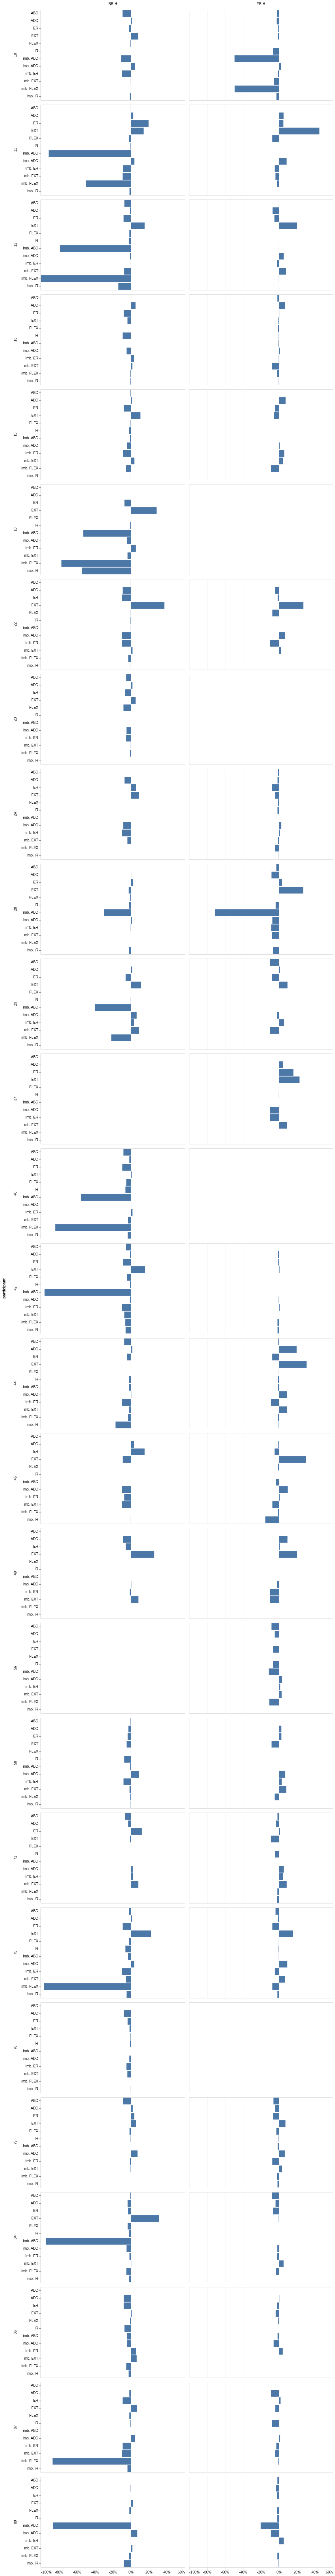

In [399]:
b = (
    alt.Chart()
    .mark_bar()
    .encode(
        alt.X("value", title=None, axis=alt.Axis(format="%")),
        alt.Y("variable", title=None),
    )
)
b.facet(
    data=best_melted,
    column=alt.Column("target", title=None),
    row=alt.Row("participant"),
)

In [403]:
best.query('participant == "28"')

,,ADD,ABD,ER,IR,EXT,FLEX,imb. ADD,imb. ABD,imb. ER,imb. IR,imb. EXT,imb. FLEX,obj_principal,obj_force,obj_imb,sum,participant,target
16,281,1.004553,1.000000,1.025368,0.980290,0.975316,0.993207,1.012940,0.700400,0.997706,0.976005,1.003797,1.0,0.500000,0.913201,0.955711,4.282112,28,BB-H
17,4509,0.917587,0.971949,1.032639,0.963263,1.270370,1.000000,0.926864,0.290553,0.913755,0.932907,0.920747,1.0,0.000319,7.307145,2.316622,16.931870,28,EB-H


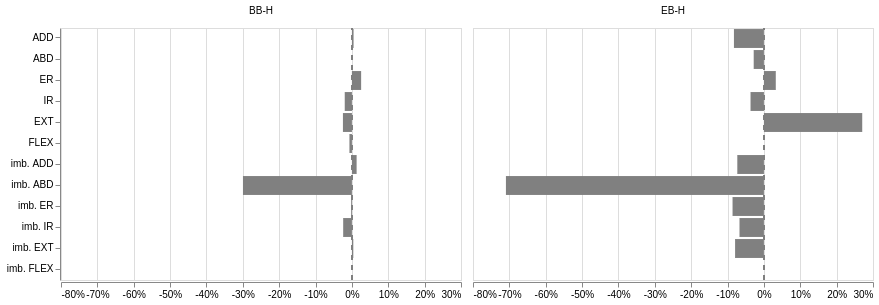

In [463]:
bar = (
    alt.Chart()
    .mark_bar(color="grey")
    .encode(
        alt.X("value", axis=alt.Axis(format="%"), title=None),
        alt.Y("variable", title=None, sort=force_cols + imb_cols),
    )
)

zero = alt.Chart().mark_rule(color="grey", strokeDash=[5, 5]).encode(alt.X("zero"))

(bar + zero).facet(
    data=best_melted.query('participant == "28"').assign(zero=0),
    column=alt.Column("target", title=None),
)

In [407]:
best.sort_values('obj_principal')

,,ADD,ABD,ER,IR,EXT,FLEX,imb. ADD,imb. ABD,imb. ER,imb. IR,imb. EXT,imb. FLEX,obj_principal,obj_force,obj_imb,sum,participant,target
38,1101,1.021120,0.914999,1.037690,0.997127,1.059287,0.985819,1.074381,1.000000,0.989214,1.000000,0.996813,1.000000,0.000056,3.038992,0.472511,6.550665,79,BB-H
17,4509,0.917587,0.971949,1.032639,0.963263,1.270370,1.000000,0.926864,0.290553,0.913755,0.932907,0.920747,1.000000,0.000319,7.307145,2.316622,16.931870,28,EB-H
25,2780,1.197563,0.993288,0.924743,0.991967,1.307418,0.997993,1.090665,0.990208,0.911823,0.995939,1.089497,0.991515,0.000595,16.220391,0.212386,32.654954,44,EB-H
1,4318,0.975040,0.977737,0.992894,0.935373,0.991081,1.000000,1.021548,0.506162,0.987935,0.972815,0.944404,0.507004,0.000808,2.113454,11.276006,15.505338,10,EB-H
24,2258,1.016575,0.926534,0.958981,0.978756,1.003686,1.000000,1.005389,0.980236,0.900000,0.829721,0.981043,0.968140,0.000912,3.656543,1.907578,9.223400,44,BB-H
27,4422,0.993529,1.000000,0.951288,1.000000,1.303341,0.991044,1.098379,0.964881,1.008383,0.848979,0.927146,0.989801,0.001047,7.511969,2.156407,17.183485,46,EB-H
36,770,0.988550,0.962332,0.926640,0.995463,1.158996,0.998767,1.092900,0.997866,0.954236,0.982505,1.066770,0.926180,0.002493,7.907441,0.582632,16.404993,75,EB-H
19,1173,1.012567,0.903994,0.922941,1.000000,1.095137,1.000000,0.979402,1.000000,1.056635,1.000000,0.900000,1.000000,0.010011,6.118830,0.194582,12.462275,29,EB-H
39,3634,0.959390,0.938835,0.936270,0.995725,1.072989,0.972117,1.063863,0.987276,0.925774,0.984259,1.034668,0.976147,0.014483,5.832903,1.125974,12.835230,79,EB-H
20,1676,1.043771,0.999433,1.161530,0.998138,1.229445,0.999598,0.902081,1.000000,0.900722,1.000000,1.091956,1.000000,0.034655,13.406768,0.014259,26.931760,37,EB-H


In [429]:
iparticipant = 11
itarget = "EB-H"
irow = X_augmented.iloc[[iparticipant]]
coeff = best.query(f'participant == "{iparticipant}" & target == "{itarget}"')

In [430]:
coeff

,,ADD,ABD,ER,IR,EXT,FLEX,imb. ADD,imb. ABD,imb. ER,imb. IR,imb. EXT,imb. FLEX,obj_principal,obj_force,obj_imb,sum,participant,target
3,3009,1.051485,1.0,1.049287,1.0,1.449914,0.925166,1.085706,1.0,0.953432,1.0,0.961526,0.978732,0.065626,5.92996,0.189865,12.246663,11,EB-H


In [431]:
t = pd.concat(
    [irow[i] * coeff[i].iloc[0] if i in best else irow[i] for i in irow.columns], axis=1
)

In [432]:
boosted[itarget].predict(irow)

array([6.994468], dtype=float32)

In [433]:
boosted[itarget].predict(t)

array([7.0184894], dtype=float32)